In [24]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Conexiión con dataset
conn = sqlite3.connect("chinook.db")


---

### **Facturación total y Clientes totales**

In [25]:
# Query
query = """
SELECT SUM(i.Total) AS "Facturación total",
COUNT(DISTINCT c.CustomerId) AS "Total clientes" 
FROM customers c
JOIN invoices i ON i.CustomerId = c.CustomerId 
"""

# Facturación total
df = pd.read_sql(query, conn)
facturacion_total = df["Facturación total"].iloc[0]
total_clientes = df["Total clientes"].iloc[-1]
df.index += 1
df.head()

,Facturación total,Clientes totales
1,2328.6,59


---

### **Facturación total por mes**

In [26]:
# Query

query = """
SELECT CASE strftime('%m', InvoiceDate)
WHEN '01' THEN 'Enero'
WHEN '02' THEN 'Febrero'
WHEN '03' THEN 'Marzo'
WHEN '04' THEN 'Abril'
WHEN '05' THEN 'Mayo'
WHEN '06' THEN 'Junio'
WHEN '07' THEN 'Julio'
WHEN '08' THEN 'Agosto'
WHEN '09' THEN 'Septiembre'
WHEN '10' THEN 'Octubre'
WHEN '11' THEN 'Noviembre'
WHEN '12' THEN 'Diciembre'
END AS Mes,
SUM(Total) AS Facturación
FROM invoices
GROUP BY strftime('%m', InvoiceDate)
ORDER BY strftime('%m', InvoiceDate)
"""

# Facturación por mes
df = pd.read_sql(query, conn)
df.index += 1
df.head(12)

,Mes,Facturación
1,Enero,201.12
2,Febrero,187.20
3,Marzo,195.10
4,Abril,198.14
5,Mayo,193.10
6,Junio,201.10
7,Julio,190.10
8,Agosto,198.10
9,Septiembre,196.20
10,Octubre,193.10


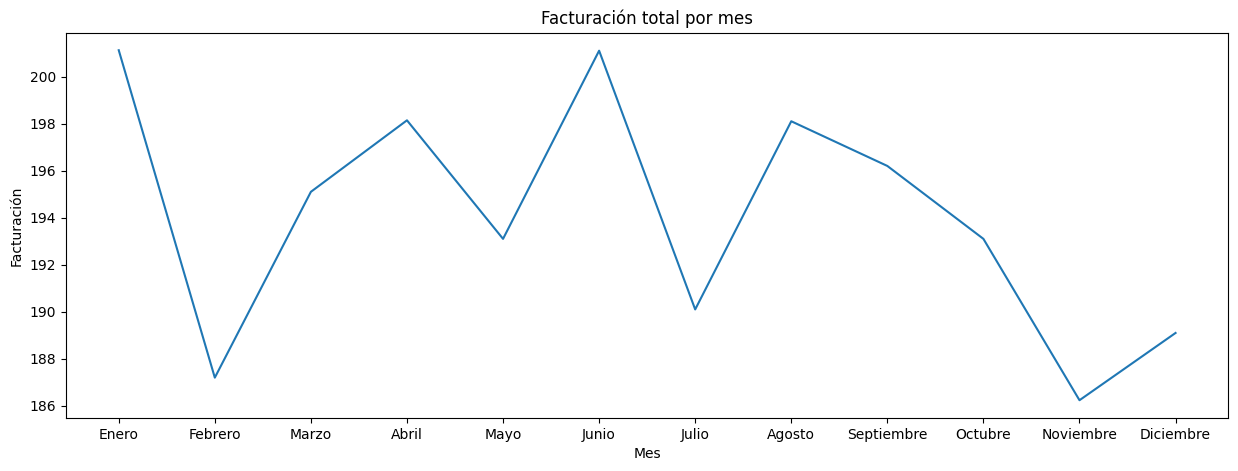

In [27]:
#Gráfico

plt.figure(figsize = (15,5))
plt.plot(df["Mes"], df["Facturación"])
plt.title("Facturación total por mes")
plt.xlabel("Mes")
plt.ylabel("Facturación")
plt.show()

---

### Análisis de la facturación mensual (2009 - 2013)

- Se observa una variabilidad moderada.
- Los valores máximos se registran en Enero (~201) y Junio (~201).
- El valor mínimo se presenta en Noviembre (~186).
- El rango de oscilación es aproximadamente 15 unidades.
- No se observa una tendencia creciente o decreciente sostenida, sino fluctuaciones mensuales.

---

### **Top 10 paises por factutación** (sobre 24 paises)

In [28]:
# Query
query = """
SELECT BillingCountry AS "Pais", SUM(Total) AS "Facturación" FROM invoices
GROUP BY BillingCountry
ORDER BY "Facturación" DESC
LIMIT 10
"""

# Top 10 paises
df = pd.read_sql(query, conn)
df.index += 1
df.head(10)

,Pais,Facturación
1,USA,523.06
2,Canada,303.96
3,France,195.10
4,Brazil,190.10
5,Germany,156.48
6,United Kingdom,112.86
7,Czech Republic,90.24
8,Portugal,77.24
9,India,75.26
10,Chile,46.62


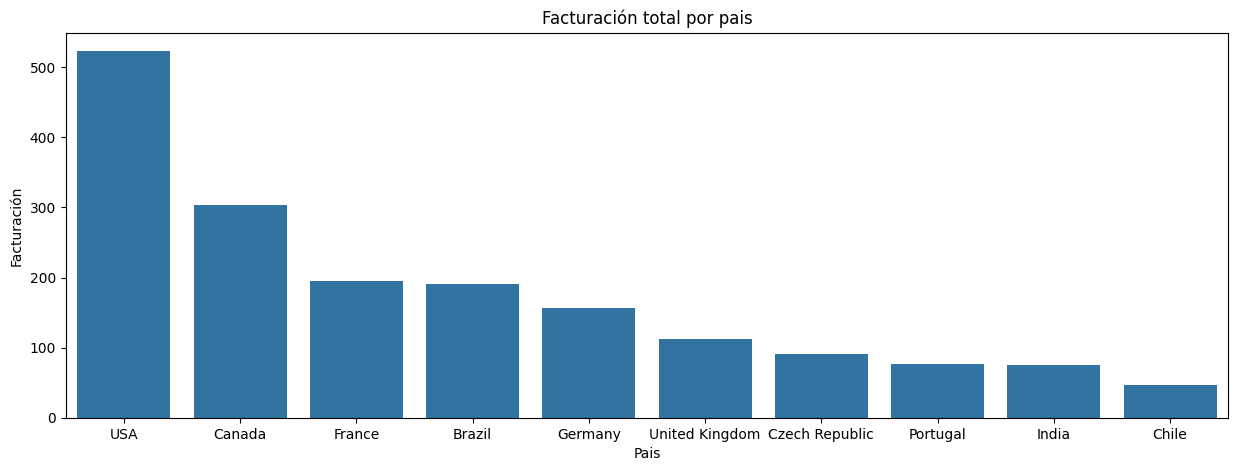

In [29]:
#Gráfico

plt.figure(figsize = (15,5))
sns.barplot(data = df, x = "Pais", y = "Facturación")
plt.title("Facturación total por pais")
plt.xlabel("Pais")
plt.ylabel("Facturación")
plt.show()

---

### Análisis de facturación por país

- **USA** presenta la mayor facturación del conjunto analizado.
- La facturación de **USA es +73% frente a Canadá**.
- La suma de **USA y Canadá representa cerca del 47% del total facturado del top 10**.
- Se observa, por lo tanto, una **alta concentración geográfica en Norteamérica**, con un liderazgo marcado de Estados Unidos sobre el resto de los países.


---

### **Top 5 Paises por cantidad de clientes**

In [30]:
# Query
query = """
SELECT CONCAT(FirstName, ' ', LastName) AS Cliente, Country AS Pais, COUNT(CustomerId) AS "Cantidad de clientes"
FROM customers
GROUP BY Country
ORDER BY "Cantidad de clientes" DESC
LIMIT 5
"""

# Top 5 paises
df = pd.read_sql(query, conn)
df.index += 1
df.head()

,Cliente,Pais,Cantidad de clientes
1,Frank Harris,USA,13
2,François Tremblay,Canada,8
3,Camille Bernard,France,5
4,Luís Gonçalves,Brazil,5
5,Leonie Köhler,Germany,4


---

### **Top 10 géneros por facturación**

In [31]:
# Query
query = """
WITH FacturacionGenero AS
(SELECT g.Name AS Género, SUM(i.Total) AS Facturación
FROM invoices i
JOIN invoice_items ii ON ii.InvoiceId = i.InvoiceId
JOIN tracks t ON t.TrackId = ii.TrackId
JOIN genres g ON g.GenreId = t.GenreId
GROUP BY Género
ORDER BY Facturación DESC
LIMIT 10)

SELECT Género, Facturación
FROM FacturacionGenero

UNION ALL
SELECT 'TOTAL TOP 10' AS Género, SUM(Facturación) AS Facturación FROM FacturacionGenero
"""

# Top 10 géneros
df = pd.read_sql(query, conn)
df.index += 1
df.head(11)

,Género,Facturación
1,Rock,7720.02
2,Latin,3472.55
3,Metal,2093.13
4,Alternative & Punk,1961.66
5,TV Shows,817.71
6,Jazz,746.46
7,Drama,544.61
8,Blues,429.66
9,R&B/Soul,338.62
10,Reggae,332.64


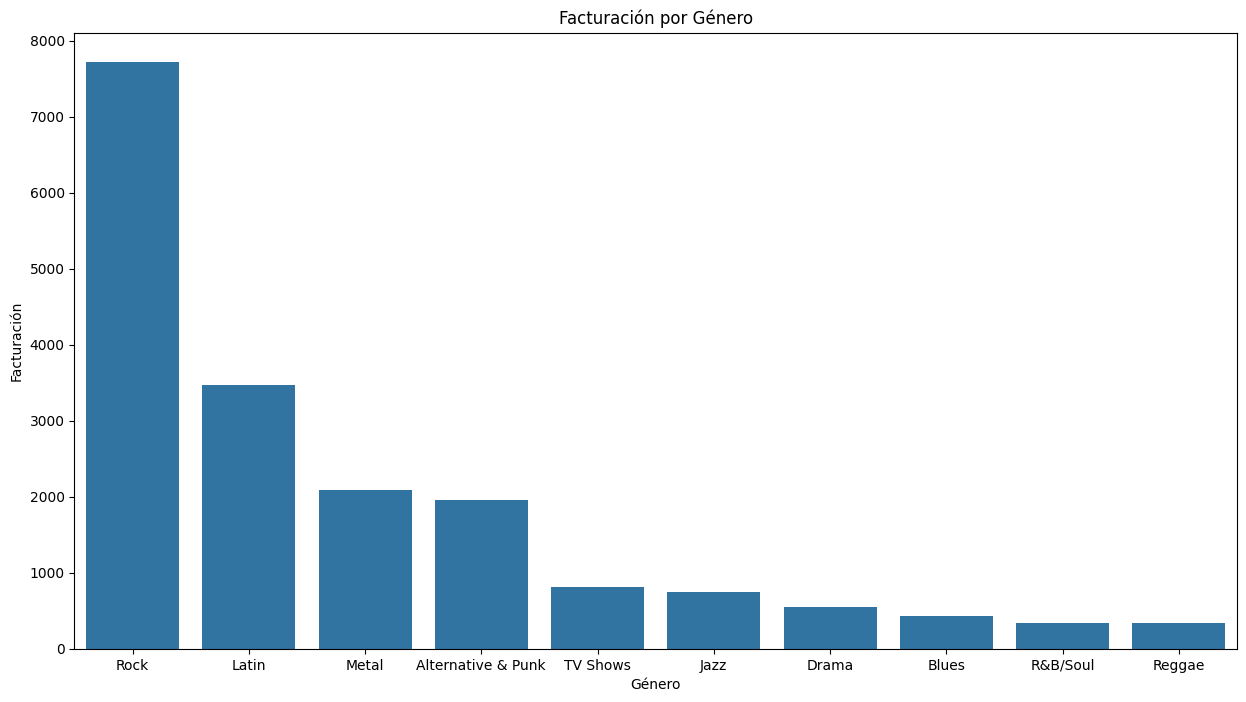

In [32]:
# Elimino TOTAL TOP 10 para el gráfico
df_plot = df[df["Género"] != "TOTAL TOP 10"]

plt.figure(figsize = (15,8))
sns.barplot(data = df_plot, x = "Género", y = "Facturación")
plt.title("Facturación por Género")
plt.show()

---

### Anánalisis de la facturación por género

- **Rock** genera **+120% que Latin**, que ocupa el segundo lugar.
- **Rock** + **Latin** generan aproximadamente el 60% de la facturación del top 10.
- **Metal** y **Alternative & Punk** forman un tercer escalón con valores similares entre sí.
- El resto de géneros está por debajo del 50% que facturó **Metal**.

---

### Facturación por género en Estados Unidos

In [33]:
# Query

query = """
WITH FacturacionGenero AS
(SELECT g.Name AS Género, SUM(i.Total) AS Facturación
FROM invoices i
JOIN invoice_items ii ON ii.InvoiceId = i.InvoiceId
JOIN tracks t ON t.TrackId = ii.TrackId
JOIN genres g ON g.GenreId = t.GenreId
WHERE i.BillingCountry = 'USA'
GROUP BY Género
ORDER BY Facturación DESC
LIMIT 10)

SELECT Género, Facturación
FROM FacturacionGenero

UNION ALL
SELECT 'TOTAL TOP 10' AS Género, SUM(Facturación) AS Facturación FROM FacturacionGenero
"""

df = pd.read_sql(query, conn)
df.index += 1
df.head(11)

,Género,Facturación
1,Rock,1526.14
2,Latin,754.67
3,Metal,554.45
4,Alternative & Punk,415.92
5,Jazz,202.95
6,TV Shows,191.70
7,Drama,143.16
8,Blues,126.72
9,Comedy,90.44
10,Classical,87.20


---

> **Rock** también predomina en **USA** con +100% de facturación respecto a **Latin**

---

### **Top 10 clientes por facturación**

In [34]:
# Query

query = """ 
WITH Top10 AS 
(SELECT c.CustomerId, CONCAT(c.FirstName, ' ', c.LastName) AS Cliente, SUM(i.Total) AS Facturación
FROM customers c
JOIN invoices i ON c.CustomerId = i.CustomerId
GROUP BY c.CustomerId
ORDER BY Facturación DESC
LIMIT 10)
SELECT Cliente, Facturación FROM Top10

UNION ALL
SELECT 'TOTAL TOP 10' AS Cliente, SUM(Facturación) AS Facturación FROM Top10
"""

df = pd.read_sql(query, conn)
df.index += 1
display(df.head(11))

# Facturacion del top 10 clientes
top10 = df["Facturación"].iloc[-1]
top10_porcentaje = top10 / facturacion_total * 100 
print(f"Porcentaje de facturación top 10: {top10_porcentaje:.3f}")

,Cliente,Facturación
1,Helena Holý,49.62
2,Richard Cunningham,47.62
3,Luis Rojas,46.62
4,Ladislav Kovács,45.62
5,Hugh O'Reilly,45.62
6,Frank Ralston,43.62
7,Julia Barnett,43.62
8,Fynn Zimmermann,43.62
9,Astrid Gruber,42.62
10,Victor Stevens,42.62


Porcentaje de facturación top 10: 19.376


---



> El top 10 clientes genera **∼19.38%** de la facturación total sobre 59 clientes totales.

---
---

### **Conclusiones generales**

- **Estados Unidos** concentra la mayor facturación y base de clientes, posicionándose como el mercado principal.
- El género **Rock** lidera ampliamente en ingresos, superando de forma consistente al resto de los géneros.
- La alta facturación de **Rock** está fuertemente asociada al mercado estadounidense, lo que sugiere concentración geográfica en el consumo.
- El Top 10 de clientes representa ~19.38% de la facturación total, proporción alineada con su peso relativo en la base de clientes (~17%), sin evidencia de alta concentración de ingresos.
- No se identifican patrones estacionales marcados en la facturación mensual.